# Mask R-CNN Notebook for Cell Counting Model

## Prerequisites to running

ALWAYS run the following 2 cells. Make sure to check that you are on a GPU runtime. If you intend on using something else, make sure to change the second cell's DEVICE to reflect that.

In [1]:
# Prereqs to running
# Always run this cell first

!pip install q keras==2.2.5
#!pip install q keras==2.0.8
%tensorflow_version 1.x
!rm -r sample_data/
!git clone https://github.com/Jotanator/115CellCount && cd 115CellCount/ && git checkout Mask_RCNN_notebook
%cd 115CellCount/samples/balloon

     |████████████████████████████████| 337kB 8.1MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
TensorFlow 1.x selected.
Cloning into '115CellCount'...
remote: Enumerating objects: 746, done.
remote: Counting objects: 100% (239/239), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 746 (delta 123), reused 167 (delta 72), pack-reused 507
Receiving objects: 100% (746/746), 177.60 MiB | 35.50 MiB/s, done.
Resolving deltas: 100% (290/290), done.
Checking out files: 100% (196/196), done.
Branch 'Mask_RCNN_notebook' set up to track remote branch 'Mask_RCNN_notebook' from 'origin'.
Switched to a new branch 'Mask_RCNN_notebook'
/content/115CellCount/samples/balloon


In [ ]:
!cd ../../datasets/balloon/ && rm -r train && rm -r val && unzip z.zip

Archive:  z.zip
  inflating: val/via_region_data.json  
  inflating: val/92.1 cells (091520, P9, 10X).json  
  inflating: val/Omm1 cells (101320, P14, 10X).json  
  inflating: val/92.1 cells (091520, P12, 20X).json  
  inflating: val/92.1 cells (092820, P10, 10X, S2).json  
  inflating: val/Mel202 cells (091820, P7, 10X).json  
  inflating: val/Omm1 cells (090920, P9, 10X).json  
  inflating: val/92.1 cells (092220, P9, 10X).json  
  inflating: val/92.1 cells (092820, P12, 20X, S2).json  
  inflating: val/Omm1 cells (101320, P14, 10X).jpg  
  inflating: val/Omm1 cells (090920, P9, 10X).jpg  
  inflating: val/Mel202 cells (091820, P7, 10X).jpg  
  inflating: val/92.1 cells (092820, P12, 20X, S2).jpg  
  inflating: val/92.1 cells (092820, P10, 10X, S2).jpg  
  inflating: val/92.1 cells (092220, P9, 10X).jpg  
  inflating: val/92.1 cells (091520, P12, 20X).jpg  
  inflating: val/92.1 cells (091520, P9, 10X).jpg  
  inflating: train/via_region_data.json  
  inflating: train/92.1 cells (091

In [ ]:
# Always run this cell second

import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

#from samples.balloon
import balloon

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
#print(MODEL_DIR)

# Path to balloon data folder that contains train/ and val/
config = balloon.BalloonConfig()
BALLOON_DIR = os.path.join(ROOT_DIR, "datasets/balloon")
#print(BALLOON_DIR)

class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
#config.display()

DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

TEST_MODE = "inference"
def get_ax(rows=1, cols=1, size=16):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Using TensorFlow backend.


## Predicting

Run the below cells for running predictions on data in the val folder.
The images you want to predict on must be included in the via_region_data.json file to be valid. You will need to upload your .h5 file to samples/balloon and change the weights_path to point to it. DO NOT run the cell the loads the model until the .h5 is finished uploading or else you might corrupt it and need to redownload it.

In [ ]:
# Load validation dataset
dataset = balloon.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "val")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 1
Classes: ['BG', 'balloon']


In [ ]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Change this to whatever file you want to load
weights_path = os.path.join(ROOT_DIR, "samples/balloon/mask_rcnn_balloon_0030.h5")

model.load_weights(weights_path, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


image ID: balloon.92.1 cells (092820, P12, 20X, S2).jpg (0) /content/115CellCount/datasets/balloon/val/92.1 cells (092820, P12, 20X, S2).jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (17,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (17, 4)               min:    1.00000  max: 1023.00000  int32
gt_mask                  shape: (1024, 1024, 17)      min:    0.00000  max:    1.00000  bool


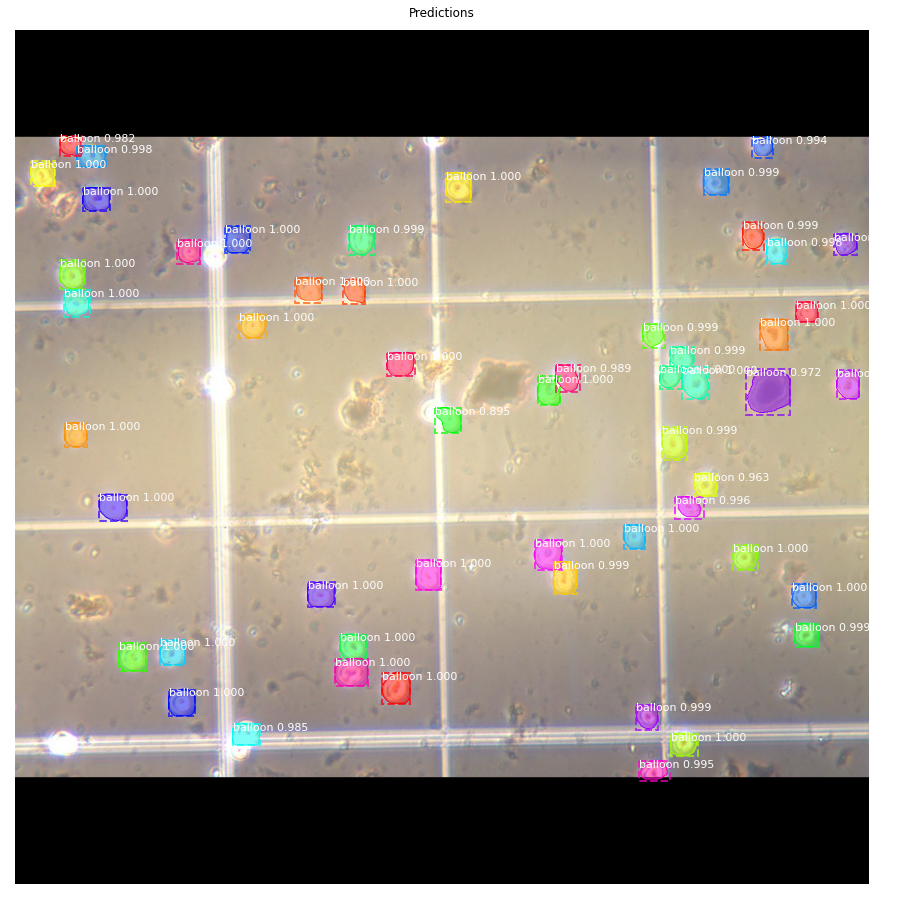

In [ ]:
# Change this to any specific id you might want, or random choice
image_id = 0
#image_id = random.choice(dataset.image_ids)

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Training

Run the below cell while current directory is inside samples/balloon. If it gives an error, try using a different keras version in the cell at the top of the notebook. You will need to restart your runtime and you will need to rerun the cells. Your files will all still be there.

In [ ]:
#Train a new model starting from ImageNet weights
!python3 balloon.py train --dataset=../../datasets/balloon/ --weights=imagenet

#Train a new model starting from pre-trained COCO weights
#!python3 balloon.py train --dataset=../../datasets/balloon/ --weights=coco

#Resume training a model that you had trained earlier
#!python3 balloon.py train --dataset=../../datasets/balloon/ --weights=last

Using TensorFlow backend.
Weights:  imagenet
Dataset:  ../../datasets/balloon/
Logs:  /content/115CellCount/logs

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_